<a href="https://colab.research.google.com/github/camillabocciolone/Leonardo-project/blob/main/ll2egpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import necessari librerie e files

## import libraries

In [1]:
!pip -q install einops tqdm scikit-learn scipy

import os, sys, numpy as np, torch
from pathlib import Path
from scipy.signal import resample_poly
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import os, json
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, iirnotch, resample_poly, detrend
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



## --- Repo EEGPT ---

In [2]:
# (opzionale) aggiorna pip/setuptools/wheel per massimizzare compatibilità
!pip install -U pip setuptools wheel

# install minimo per il tuo script
!pip install numpy scipy scikit-learn einops tqdm

# torch: in Colab di solito è già installato; se no:
!pip install torch --index-url https://download.pytorch.org/whl/cpu



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Looking in indexes: https://download.pytorch.org/whl/cpu


## montare il drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Usa il checkpoint direttamente da Drive

In [4]:
from pathlib import Path

ckpt_path = Path(
    "/content/drive/MyDrive/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt"
)

print("Checkpoint exists:", ckpt_path.exists())


Checkpoint exists: True


## Clona il repo

In [5]:
from pathlib import Path
import os

%cd /content
if not Path("/content/EEGPT").exists():
    !git clone -q https://github.com/BINE022/EEGPT.git

print("Repo OK:", Path("/content/EEGPT").exists())
print("Has downstream:", Path("/content/EEGPT/downstream").exists())


/content
Repo OK: True
Has downstream: True


## Import del modello

In [6]:
import importlib.util
from pathlib import Path

path = Path("/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py")
print("Model file exists:", path.exists(), path)

spec = importlib.util.spec_from_file_location("eegpt_mcae_finetune", str(path))
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

EEGPTClassifier = mod.EEGPTClassifier
CHANNEL_DICT = mod.CHANNEL_DICT

print("Import OK. CHANNEL_DICT size:", len(CHANNEL_DICT))


Model file exists: True /content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py
Import OK. CHANNEL_DICT size: 62


/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:679: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)
/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:693: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)


## Crea il modello usando il checkpoint dal Drive

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
channels = [c.upper().strip('.') for c in my_channels]

for c in channels:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto: {c}"
print("Channels:", channels)

print("Checkpoint exists:", ckpt_path.exists(), ckpt_path)

# ricrea il modello coerente col checkpoint (31 patch * 64 = 1984)
model = EEGPTClassifier(
    num_classes=4,
    in_channels=58,
    img_size=[58, 1984],          # IMPORTANTISSIMO
    patch_stride=64,
    desired_time_len=1984,        # IMPORTANTISSIMO
    use_channels_names=channels,  # i tuoi 8 canali dentro i 58
    ckpt_path=str(ckpt_path),     # checkpoint dal Drive
).to(device)




print("Model init OK")



Device: cuda
Channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']
Checkpoint exists: True /content/drive/MyDrive/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt
Model init OK


# proviamo EEGPT con dataset fittizio

## Assunzioni
- stai usando 58 canali
- finestra 4s @ 256Hz → 1024

## STEP 1 — Dataset finto
Questo dataset produce:
- x: (B, 58, 1024)
- y: {0,1,2}

In [ ]:
import torch
from torch.utils.data import Dataset

class DummyEEGDataset(Dataset):
    def __init__(self, n_samples=300):
        self.n = n_samples

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = torch.randn(58, 1024)     # EEG finto
        y = torch.randint(0, 3, (1,)).item()
        return x, y

class DummyEEGDataset(Dataset):
    def __init__(self, n_samples=300, windows_per_recording=5):
        self.n = n_samples
        self.wpr = windows_per_recording   # (1)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = torch.randn(58, 1024)
        recording_id = idx // self.wpr     # (2)
        y = recording_id % 3               # (3) label coerente per recording
        return x, y, recording_id          # (4)


## STEP 2 — DataLoader

In [ ]:

train_ds = DummyEEGDataset(300)
test_ds  = DummyEEGDataset(60)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=16)


## STEP 3 — Modello EEGPT


In [ ]:
import sys
from pathlib import Path
sys.path.append("/content/EEGPT")

import torch
from downstream.Modules.models.EEGPT_mcae_finetune import EEGPTClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_path = "/content/drive/MyDrive/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt"

from downstream.Modules.models.EEGPT_mcae_finetune import CHANNEL_DICT

model = EEGPTClassifier(
    num_classes=3,
    in_channels=58,
    img_size=[58, 1024],
    patch_stride=64,
    ckpt_path=ckpt_path,
    use_channels_names=list(CHANNEL_DICT.keys())[:58],  # <-- FIX QUI
).to(device)




## STEP 4 — Congela encoder (linear probing)

In [ ]:
for p in model.target_encoder.parameters():
    p.requires_grad = False


## STEP 5 — Training loop + feature extraction

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

all_features = []
all_labels   = []
all_rec_ids  = []

for epoch in range(3):
    model.train()
    for x, y, rec_id in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        # ====== FEATURE EXTRACTION ======
        feats = model.forward_features(x)   # (B, D)
        logits = model.head(feats)

        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        all_features.append(feats.cpu())
        all_labels.append(y.cpu())
        all_rec_ids.append(rec_id.cpu())


    print(f"Epoch {epoch} done")


## STEP 6 — Salva feature

In [ ]:
features = torch.cat(all_features)
labels   = torch.cat(all_labels)
rec_ids  = torch.cat(all_rec_ids)

torch.save({
    "features": features,
    "labels": labels,
    "rec_ids": rec_ids
}, "eegpt_features.pt")

print("Saved features:", features.shape)



## TSN

a differenza del training precedente in cui predicevo per ogni window la classe qui

registrazione EEG
 → finestre
 → aggregazione (media / attention)
 → 1 predizione


In [ ]:
import torch

data = torch.load("eegpt_features.pt")

features = data["features"]   # (N, D)
labels   = data["labels"]     # (N,)
rec_ids  = data["rec_ids"]    # (N,)

print(features.shape, labels.shape, rec_ids.shape)


In [ ]:
unique_rec_ids = torch.unique(rec_ids)

X_tsn = []
y_tsn = []

for rid in unique_rec_ids:
    mask = rec_ids == rid
    feats_r = features[mask]      # (K, D)
    label_r = labels[mask][0]     # stessa label per recording

    X_tsn.append(feats_r.mean(dim=0))  # TSN = average pooling
    y_tsn.append(label_r)

X_tsn = torch.stack(X_tsn)   # (N_rec, D)
y_tsn = torch.stack(y_tsn)   # (N_rec,)

print("TSN features:", X_tsn.shape)
print("TSN labels:", y_tsn.shape)


In [ ]:
import torch.nn as nn
import torch.optim as optim

num_classes = 3
clf = nn.Linear(X_tsn.shape[1], num_classes)

optimizer = optim.Adam(clf.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


### Training classifier

In [ ]:
# 1) forza X_tsn ad essere un "dato" puro (senza grafo)
X_tsn = X_tsn.detach().clone()
y_tsn = y_tsn.detach().clone()

print("X_tsn.requires_grad:", X_tsn.requires_grad)
print("X_tsn.grad_fn:", X_tsn.grad_fn)  # deve essere None


for epoch in range(30):
    optimizer.zero_grad()
    logits = clf(X_tsn)
    loss = criterion(logits, y_tsn)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        acc = (logits.argmax(1) == y_tsn).float().mean().item()
        print(f"Epoch {epoch:02d} | loss={loss.item():.3f} | acc={acc:.3f}")



### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

with torch.no_grad():
    preds = clf(X_tsn).argmax(dim=1)

cm = confusion_matrix(y_tsn.numpy(), preds.numpy())
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(
    y_tsn.numpy(),
    preds.numpy(),
    digits=3
))


### tsne plot

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ============================
# 1) USA LE FEATURE TSN
# ============================
X_emb = X_tsn.numpy()
y_emb = y_tsn.numpy()

print("Embedding shape:", X_emb.shape)

# ============================
# 2) NORMALIZZAZIONE
# ============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_emb)

# ============================
# 3) PCA (consigliata prima di t-SNE)
# ============================
pca = PCA(n_components=min(30, X_scaled.shape[1]), random_state=0)
X_pca = pca.fit_transform(X_scaled)

# ============================
# 4) t-SNE
# ============================
tsne = TSNE(
    n_components=2,
    perplexity=15,   # 60 campioni → 10–20 va meglio di 30
    init="pca",
    learning_rate="auto",
    random_state=0
)

X_tsne = tsne.fit_transform(X_pca)

# ============================
# 5) PLOT
# ============================
plt.figure(figsize=(7,6))
scatter = plt.scatter(
    X_tsne[:,0],
    X_tsne[:,1],
    c=y_emb,
    cmap="viridis",
    s=40,
    alpha=0.8
)
plt.colorbar(scatter, label="Class")
plt.title("t-SNE of EEGPT TSN embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


# EEGPT on the true dataset

Mounted at /content/drive
Epoche ottenute: (14, 5120)


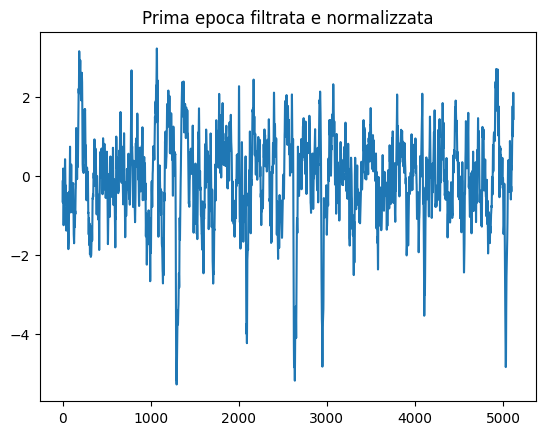

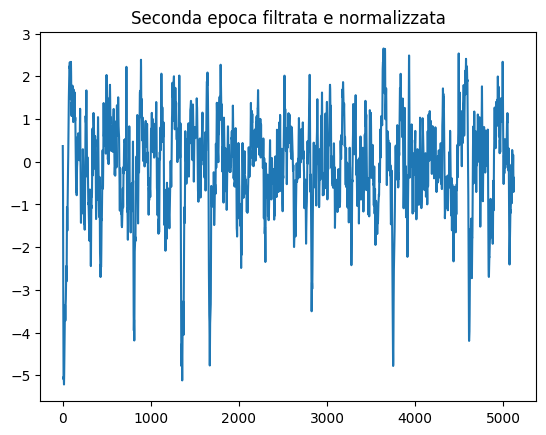

Epoche ottenute: (19, 5120)


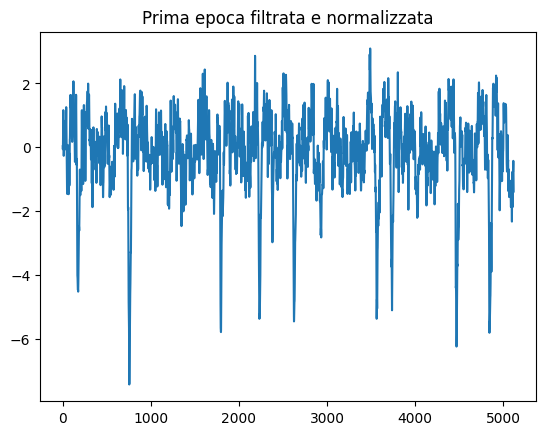

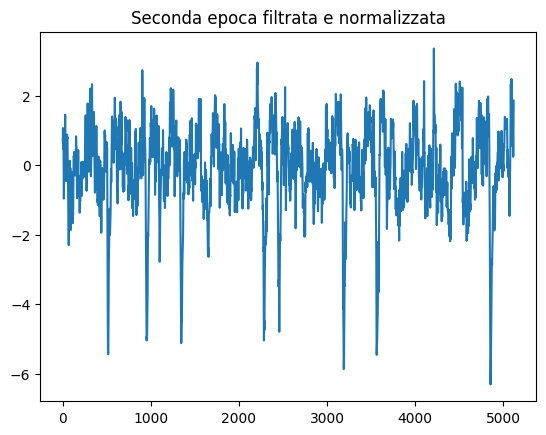

Epoche ottenute: (16, 5120)


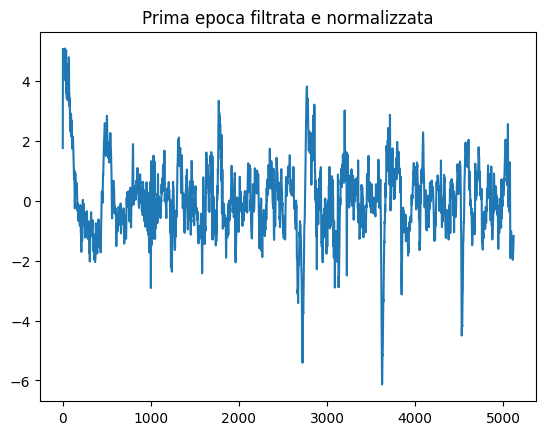

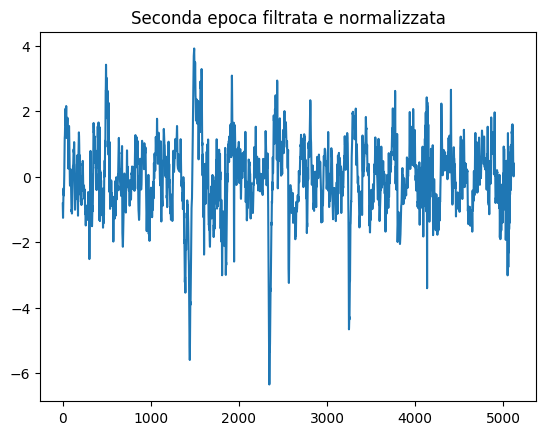

In [8]:
# --- MOUNT DRIVE E IMPORT ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, iirnotch, resample_poly
from sklearn.model_selection import GroupKFold, GroupShuffleSplit

# Percorso base dei dati
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

# --- PARAMETRI ---
FS_OUT = 256
BP_LO, BP_HI = 0.5, 45
NOTCH_F0, NOTCH_Q = 50, 30
EPOCH_SEC = 20
STRIDE_SEC = EPOCH_SEC/4
N_FOLDS, RNG_SEED = 5, 42


# --- LETTURA FILE ---
def load_eeg_data(task, level, channel_id=None, subject_id=None):
    file_path = os.path.join(data_dir, f"{task}_Data", f"{level}-{subject_id}.txt")
    if not os.path.exists(file_path):
        print(f"File non trovato: {file_path}")
        return None

    df = pd.read_csv(file_path, sep=",", header=None, engine="python")

    # 🔴 elimina la prima riga (quella con istante 0 e valori bruttissimi)
    df = df.iloc[1:, :].reset_index(drop=True)

    # colonna tempo
    df["Time"] = pd.to_numeric(df.iloc[:, 22], errors="coerce")

    # ora fai partire il tempo da zero usando il PRIMO campione BUONO
    df["Time"] = df["Time"] - df["Time"].iloc[0]

    if channel_id is not None:
        df = pd.DataFrame({
            "EEG Signal": df.iloc[:, channel_id],
            "Time": df["Time"]
        })
    return df



# --- FILTRI ---
def bandpass(x, fs, lo=BP_LO, hi=BP_HI, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch50(x, fs, f0=NOTCH_F0, Q=NOTCH_Q):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def resample_to(x, fs_in, fs_out): #credo da modificare
    if fs_in == fs_out:
        return x
    from math import gcd
    g = gcd(int(fs_in), int(fs_out))
    up, down = fs_out//g, fs_in//g
    return resample_poly(x, up=up, down=down, axis=0)


# --- NORMALIZZAZIONE E EPOCHING ---
def zscore_epochwise(x):
    m = x.mean(axis=0, keepdims=True)
    s = x.std(axis=0, keepdims=True) + 1e-8
    return (x - m) / s

def epoch_signal(x, fs, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC):
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    n = len(x)
    starts = np.arange(0, n - win + 1, step)
    epochs = np.stack([x[s:s+win] for s in starts])
    return epochs, starts


from scipy.signal import detrend

def robust_clip(x, q=0.999):              # taglia outlier pesanti
    hi = np.quantile(x, q, axis=-1, keepdims=True)
    lo = np.quantile(x, 1-q, axis=-1, keepdims=True)
    return np.clip(x, lo, hi)

def preprocess_single_channel(df, fs_in=250):
    # usa solo la colonna "EEG Signal"
    x = df["EEG Signal"].to_numpy()      # shape: (n_samples,)

    x = bandpass(x, fs_in)               # 0.5–45
    x = notch50(x, fs_in)                # 50 Hz
    x = detrend(x, axis=-1, type='linear')
    x = robust_clip(x, q=0.999)
    x = resample_to(x, fs_in, FS_OUT)

    epochs, _ = epoch_signal(x, FS_OUT)  # ora x è 1D → epochs: (N, win)

    if len(epochs) == 0:
        return epochs

    # z-score robusto per epoca
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    epochs = (epochs - med) / (1.4826 * mad)
    return epochs



# --- ESEMPIO USO ---
# 1)
task = "Stroop"
level = "highlevel"
subject = 3
channel = 3

df = load_eeg_data(task, level, channel, subject)
epochs = preprocess_single_channel(df, fs_in=250)

print("Epoche ottenute:", epochs.shape)  # (N, 1024)
plt.plot(epochs[0])
plt.title("Prima epoca filtrata e normalizzata")
plt.show()

plt.plot(epochs[1])
plt.title("Seconda epoca filtrata e normalizzata")
plt.show()

# 2)

task = "Stroop"
level = "highlevel"
subject = 1
channel = 3

df = load_eeg_data(task, level, channel, subject)
epochs = preprocess_single_channel(df, fs_in=250)

print("Epoche ottenute:", epochs.shape)  # (N, 1024)
plt.plot(epochs[0])
plt.title("Prima epoca filtrata e normalizzata")
plt.show()

plt.plot(epochs[1])
plt.title("Seconda epoca filtrata e normalizzata")
plt.show()

# 3)

task = "Stroop"
level = "highlevel"
subject = 7
channel = 3

df = load_eeg_data(task, level, channel, subject)
epochs = preprocess_single_channel(df, fs_in=250)

print("Epoche ottenute:", epochs.shape)  # (N, 1024)
plt.plot(epochs[0])
plt.title("Prima epoca filtrata e normalizzata")
plt.show()

plt.plot(epochs[1])
plt.title("Seconda epoca filtrata e normalizzata")
plt.show()




In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.mlab as mlab

fig, (ax0, ax1) = plt.subplots(2, 1, layout='constrained')
ax0.plot(epochs[0])
plt.title("Prima epoca filtrata")

plt.psd(epochs[0], NFFT=512, Fs=FS_OUT)
plt.title("Power Spectral Density – Epoca 0, canale 0")
plt.xlabel("Frequenza [Hz]")
plt.ylabel("PSD")
plt.show()

## Proviamo preprocessing su tutti i canali

### non assumendo timestamp equidistanti

In [ ]:
def load_ct_matrix_with_time(path, C):
    df = pd.read_csv(path, sep=",", header=None, engine="python")

    # segnali EEG: prime C colonne
    if df.shape[1] < C:
        C_actual = df.shape[1]
        X = df.iloc[:, :C_actual].to_numpy(dtype=float).T  # (C_actual, T)
    else:
        X = df.iloc[:, :C].to_numpy(dtype=float).T         # (C, T)

    # colonna tempo (indice 22)
    t = pd.to_numeric(df.iloc[:, 22], errors="coerce").to_numpy()  # shape (T,)
    # togli NaN
    mask = ~np.isnan(t)
    t = t[mask]
    X = X[:, mask]   # tieni solo i campioni dove il tempo è definito

    # opzionale: porta il tempo a partire da 0
    t = t - t[0]

    return X, t      # X: (C, T), t: (T,)

from scipy.interpolate import interp1d
from scipy.signal import detrend

def preprocess_recording(X_ct, t_vec):
    """
    X_ct: (C, T)  = canali x tempo (tempi NON equidistanti)
    t_vec: (T,)   = tempi originali (in secondi, crescenti)
    Ritorna: epochs (N, C, win)
    """
    C, T = X_ct.shape

    # --- 1) Interpolazione su griglia uniforme a fs_in ---
    # tempo da 0 all'ultimo campione, con passo 1/fs_in
    t0 = t_vec[0]
    t  = t_vec - t0           # parti da 0
    dt = 1.0 / fs_in         # 1/250 s
    t_uniform = np.arange(0, t[-1], dt)   # (T_u,)

    # interpolatore multi-canale lungo axis=1
    f = interp1d(t, X_ct, kind="linear", axis=1,
                 bounds_error=False, fill_value="extrapolate")
    X_eq = f(t_uniform)      # (C, T_u) campioni ora equidistanti

    # ora possiamo considerare X_eq campionato a fs_in in modo corretto
    C_eq, T_eq = X_eq.shape

    # --- 2) calcolo lunghezza minima per filtfilt (come prima) ---
    b_bp, a_bp = butter(4, [BP_LO/(fs_in/2), BP_HI/(fs_in/2)], btype="band")
    b_notch, a_notch = iirnotch(w0=NOTCH_F0/(fs_in/2), Q=NOTCH_Q)

    padlen_bp    = 3 * (max(len(a_bp),    len(b_bp))    - 1)
    padlen_notch = 3 * (max(len(a_notch), len(b_notch)) - 1)
    min_len = max(padlen_bp, padlen_notch)

    if T_eq <= min_len:
        print(f"[SKIP] Signal too short after interp ({T_eq} samples) for filtering (needs > {min_len}).")
        return np.empty((0, C, int(EPOCH_SEC*FS_OUT)))

    # --- 3) preprocess sul tempo (come prima, ma usando X_eq) ---
    x = X_eq.T                   # (T_eq, C)
    x = bandpass(x, fs_in)       # 0.5–45 Hz
    x = notch50(x, fs_in)        # 50 Hz
    x = detrend(x, axis=0, type='linear')
    x = robust_clip(x, q=0.999)
    x = resample_to(x, fs_in, FS_OUT)   # 250 → 256, x: (T_res, C)

    # --- 4) epoching ---
    epochs, _ = epoch_signal(x, FS_OUT)   # (N, win, C)
    if epochs.shape[0] == 0:
        return np.empty((0, C, int(EPOCH_SEC*FS_OUT)))

    epochs = np.transpose(epochs, (0, 2, 1))   # (N, C, win)

    # --- 5) z-score robusto (per canale, per epoca) ---
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    epochs = (epochs - med) / (1.4826 * mad)

    return epochs   # (N, C, win)
def build_all(levels, tasks, subjects, C):
    X_all, y_all, subj_all, task_all, level_all = [], [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] non trovato: {level}/{task} S{s}")
                    continue
                try:
                    X_ct, t_vec = load_ct_matrix_with_time(path, C)
                    epochs = preprocess_recording(X_ct, t_vec)   # (N, C, win)
                    if epochs.shape[0] == 0:
                        print(f"[SKIP] troppe poche samples: {os.path.basename(path)}")
                        continue
                    X_all.append(epochs)
                    y_all.extend([li]*len(epochs))
                    subj_all.extend([f"S{s}"]*len(epochs))
                    task_all.extend([task]*len(epochs))
                    level_all.extend([level]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] Processing {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_all, axis=0) if X_all else np.empty((0, C, int(EPOCH_SEC*FS_OUT)))
    y_all = np.array(y_all, dtype=int)
    meta = {
        "subject": np.array(subj_all),
        "task":    np.array(task_all),
        "level":   np.array(level_all)
    }
    return X_all, y_all, meta



### assumendo timestamps equidistanti

In [ ]:
# ====== SETUP MINIMO (COLAB-FRIENDLY) ======
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, json
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, iirnotch, resample_poly
from sklearn.model_selection import GroupKFold, GroupShuffleSplit

# ---- PARAMETRI DA CAMBIARE SE SERVE ----
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

# ATTENZIONE ai nomi: qui fissiamo chiaramente cosa è cosa:
levels = ["highlevel", "midlevel", "lowlevel"]      # livelli (questi saranno le y = 0,1,2)
tasks  = ["Stroop", "Arithmetic"]                   # task (cartelle o nomi file)
subjects = range(1, 16)
C = 8          # numero canali EEG (prime C colonne del file)
fs_in = 250     # frequenza originale
FS_OUT = 256    # target
EPOCH_SEC, STRIDE_SEC = 4.0, 2.0
BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0
N_FOLDS, RNG_SEED = 5, 42

# ---- TROVA IL FILE (supporta entrambe le strutture) ----
def find_file(level, task, subject):
    # Caso A (quello che usavi in un punto):  {level}_Data / {task}-{subject}.txt
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    # Caso B (l’altro che avevamo usato):     {task}_Data / {level}-{subject}.txt
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

# ---- CARICA MATRICE EEG (C,T) dalle prime C colonne ----
def load_ct_matrix(path, C):
    df = pd.read_csv(path, sep=",", header=None, engine="python")
    if df.shape[1] < C:
        # print(f"Warning: {path}: expected >= {C} columns, found {df.shape[1]}. Taking first {df.shape[1]} columns.")
        C_actual = df.shape[1] # Use actual number of columns if less than C
        X = df.iloc[:, :C_actual].to_numpy(dtype=float).T  # (C_actual, T)
    else:
        X = df.iloc[:, :C].to_numpy(dtype=float).T  # (C,T)
    return X

# ---- PREPROCESS COMPLETO DI UNA REGISTRAZIONE ----
def preprocess_recording(X_ct):
    """
    X_ct: array (C, T)  = canali x tempo
    Ritorna: epochs con shape (N, C, win)
    """
    C, T = X_ct.shape

    # --- calcolo lunghezza minima per filtfilt ---
    b_bp, a_bp = butter(4,
                        [BP_LO/(fs_in/2), BP_HI/(fs_in/2)],
                        btype="band")
    b_notch, a_notch = iirnotch(w0=NOTCH_F0/(fs_in/2), Q=NOTCH_Q)

    padlen_bp    = 3 * (max(len(a_bp),    len(b_bp))    - 1)
    padlen_notch = 3 * (max(len(a_notch), len(b_notch)) - 1)
    min_len = max(padlen_bp, padlen_notch)

    if T <= min_len:
        print(f"[SKIP] Signal too short ({T} samples) for filtering (needs > {min_len}).")
        return np.empty((0, C, int(EPOCH_SEC*FS_OUT)))

    # --- preprocess sul tempo ---
    x = X_ct.T                  # (T, C): tempo x canali
    x = bandpass(x, fs_in)      # 0.5–45 Hz
    x = notch50(x, fs_in)       # 50 Hz
    x = detrend(x, axis=0, type='linear')
    x = robust_clip(x, q=0.999)         # limite outlier
    x = resample_to(x, fs_in, FS_OUT)   # 250→256, x: (T_res, C)

    # --- epoching ---
    epochs, _ = epoch_signal(x, FS_OUT)   # (N, win, C)
    if epochs.shape[0] == 0:
        return np.empty((0, C, int(EPOCH_SEC*FS_OUT)))

    # porta a (N, C, win)
    epochs = np.transpose(epochs, (0, 2, 1))

    # --- z-score robusto per epoca (per canale) ---
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    epochs = (epochs - med) / (1.4826 * mad)

    return epochs   # (N, C, win)






# ---- BUILD: crea X_all, y_all, meta ----
def build_all(levels, tasks, subjects, C):
    X_all, y_all, subj_all, task_all, level_all = [], [], [], [], []
    for li, level in enumerate(levels):           # li = etichetta (0,1,2)
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] non trovato: {level}/{task} S{s}")
                    continue
                try:
                    X_ct = load_ct_matrix(path, C)
                    epochs = preprocess_recording(X_ct)   # (N, C, win)
                    if epochs.shape[0]==0:
                        print(f"[SKIP] troppe poche samples: {os.path.basename(path)}")
                        continue
                    X_all.append(epochs)
                    y_all.extend([li]*len(epochs))          # y = livello
                    subj_all.extend([f"S{s}"]*len(epochs))  # gruppi per split
                    task_all.extend([task]*len(epochs))
                    level_all.extend([level]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] Processing {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_all, axis=0) if X_all else np.empty((0, C, int(EPOCH_SEC*FS_OUT)))
    y_all = np.array(y_all, dtype=int)
    meta = {"subject": np.array(subj_all), "task": np.array(task_all), "level": np.array(level_all)}
    return X_all, y_all, meta


## SPLIT 5-FOLD SUBJECT-INDEPENDENT

In [ ]:

def make_subject_folds(subj_vec, n_splits=N_FOLDS, seed=RNG_SEED):
    groups = subj_vec
    gkf = GroupKFold(n_splits=n_splits)
    folds = []
    for (trainval_idx, test_idx) in (split for _, split in enumerate(gkf.split(np.zeros_like(groups), groups=groups))):
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
        tr_rel, va_rel = next(gss.split(trainval_idx, groups=groups[trainval_idx]))
        tr, va = trainval_idx[tr_rel], trainval_idx[va_rel]
        folds.append({"train": tr, "val": va, "test": test_idx})
    return folds


X_all, y_all, meta = build_all(levels, tasks, subjects, C)
print("X_all:", X_all.shape, "| y_all:", y_all.shape)

folds = make_subject_folds(meta["subject"])
for k, split in enumerate(folds):
    trS = set(meta["subject"][split["train"]]); vaS = set(meta["subject"][split["val"]]); teS = set(meta["subject"][split["test"]])
    assert trS.isdisjoint(vaS) and trS.isdisjoint(teS) and vaS.isdisjoint(teS)
    print(f"Fold {k}: N(tr)={len(split['train'])}, N(val)={len(split['val'])}, N(te)={len(split['test'])} | "
          f"S(tr)={len(trS)}, S(val)={len(vaS)}, S(te)={len(teS)}")


## ridefiniamo build all usando rec_id

**Scopo**: oltre a subject, crea anche un ID del recording in modo che si possa fare split “a livello di registrazione” (recording-level) e poi prendere tutte le finestre di quella registrazione insieme

In [9]:
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels = ["highlevel", "midlevel", "lowlevel"]   # y=0,1,2
tasks  = ["Stroop", "Arithmetic"]
subjects = range(1, 16)

C = 8
fs_in = 250
FS_OUT = 256
EPOCH_SEC, STRIDE_SEC = 4.0, 2.0
BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0

# canali OpenBCI (devono essere in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_names = [c.upper().strip('.') for c in my_channels]
for c in use_channels_names:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto in CHANNEL_DICT: {c}"
print("Use channels:", use_channels_names)


Use channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']


## definiamo funzioni per la lettura e preprocessing dei dati

In [10]:
def find_file(level, task, subject):
    # layout A: {level}_Data/{task}-{subject}.txt
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    # layout B: {task}_Data/{level}-{subject}.txt
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

def load_ct_matrix(path, C=8):
    df = pd.read_csv(path, sep=",", header=None, engine="python")
    # prende le prime C colonne come EEG
    X = df.iloc[:, :C].to_numpy(dtype=np.float32).T  # (C,T)
    return X

def bandpass(x, fs, lo=BP_LO, hi=BP_HI, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch50(x, fs, f0=NOTCH_F0, Q=NOTCH_Q):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def resample_to(x, fs_in, fs_out):
    if fs_in == fs_out:
        return x
    # per 250->256 puoi usare direttamente 128/125
    if int(fs_in)==250 and int(fs_out)==256:
        return resample_poly(x, 128, 125, axis=0)
    # fallback generico
    from math import gcd
    g = gcd(int(fs_in), int(fs_out))
    up, down = fs_out//g, fs_in//g
    return resample_poly(x, up, down, axis=0)

def robust_clip(x, q=0.999):
    hi = np.quantile(x, q, axis=0, keepdims=True)
    lo = np.quantile(x, 1-q, axis=0, keepdims=True)
    return np.clip(x, lo, hi)

def epoch_signal(x_tc, fs, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC):
    # x_tc: (T,C)
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts)==0:
        return np.empty((0, win, x_tc.shape[1]), dtype=np.float32)
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0)  # (N, win, C)
    return epochs

def preprocess_recording(X_ct):
    # X_ct: (C,T) -> epochs: (N,C,1024)
    x = X_ct.T  # (T,C)
    x = bandpass(x, fs_in)
    x = notch50(x, fs_in)
    x = detrend(x, axis=0, type='linear')
    x = robust_clip(x, q=0.999)
    x = resample_to(x, fs_in, FS_OUT)  # (T2,C)
    epochs = epoch_signal(x, FS_OUT)   # (N,1024,C)
    if epochs.shape[0]==0:
        return np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    epochs = np.transpose(epochs, (0,2,1))  # (N,C,1024)

    # robust z-score per epoca/canale
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    epochs = (epochs - med) / (1.4826 * mad)
    return epochs.astype(np.float32)


## build_all

In [11]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:
                    X_ct = load_ct_matrix(path, C=C)
                    epochs = preprocess_recording(X_ct)  # (Nw,C,1024)
                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([li]*len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (3697, 8, 1024) y_all: (3697,) unique rec: 90


## recording-level

Questo blocco serve a fare cross-validation a livello di registrazione (non di finestra), mantenendo l’indipendenza tra soggetti, e poi usare quei recording per selezionare le finestre giuste

In [12]:
# Costruisco tabella "recording-level"
rec_ids = np.unique(meta["rec_id"])
rec_to_subject = {rid: rid.split("|")[-1] for rid in rec_ids}  # "...|S7" -> "S7"
rec_subjects = np.array([rec_to_subject[r] for r in rec_ids])

# label per recording: prendo la label della prima finestra di quel rec_id
rec_label = {}
for rid in rec_ids:
    idx = np.where(meta["rec_id"] == rid)[0][0]
    rec_label[rid] = int(y_all[idx])
rec_y = np.array([rec_label[r] for r in rec_ids], dtype=np.int64)

# 5-fold subject-independent sui recording
gkf = GroupKFold(n_splits=5)
folds = []
for trainval_idx, test_idx in gkf.split(rec_ids, rec_y, groups=rec_subjects):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_rel, va_rel = next(gss.split(trainval_idx, groups=rec_subjects[trainval_idx]))
    tr_idx = trainval_idx[tr_rel]
    va_idx = trainval_idx[va_rel]
    folds.append({"train_rec": rec_ids[tr_idx], "val_rec": rec_ids[va_idx], "test_rec": rec_ids[test_idx]})

FOLD = 0
train_rec = set(folds[FOLD]["train_rec"])
val_rec   = set(folds[FOLD]["val_rec"])
test_rec  = set(folds[FOLD]["test_rec"])

print("Fold0 recordings:", len(train_rec), len(val_rec), len(test_rec))


Fold0 recordings: 54 18 18


## da eliminare

In [ ]:
model = EEGPTClassifier(
    num_classes=3,                 # head interna non la usiamo davvero
    in_channels=58,
    img_size=[58, 1024],
    patch_stride=64,
    desired_time_len=1024,
    use_channels_names=use_channels_names,
    ckpt_path=str(ckpt_path),
).to(device)

model.eval()
for p in model.parameters():
    p.requires_grad = False  # feature extractor


WindowDataset e i DataLoader fanno solo tre cose:
- selezionano le finestre giuste con la maschera (rec_id ∈ train_rec/val_rec/test_rec)
- tengono in memoria self.X/self.y/self.r
- in __getitem__ trasformano self.X[i] e self.y[i] in tensori torch

In [15]:
class WindowDataset(Dataset):
    def __init__(self, X_all, y_all, rec_id_all, keep_rec_set):
        mask = np.array([rid in keep_rec_set for rid in rec_id_all])
        self.X = X_all[mask]               # (N,C,1024)
        self.y = y_all[mask]
        self.r = rec_id_all[mask]

    def __len__(self): return len(self.y)

    def __getitem__(self, i):
        x = torch.tensor(self.X[i], dtype=torch.float32)  # (8,1024)
        y = torch.tensor(self.y[i], dtype=torch.long)
        rid = self.r[i]
        return x, y, rid

BATCH=64
train_ds = WindowDataset(X_all, y_all, meta["rec_id"], train_rec)
val_ds   = WindowDataset(X_all, y_all, meta["rec_id"], val_rec)
test_ds  = WindowDataset(X_all, y_all, meta["rec_id"], test_rec)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False)

print("windows:", len(train_ds), len(val_ds), len(test_ds))


windows: 2271 652 774


## definizione modello

In [16]:
# lista 58 canali nell'ordine corretto (ordinati per indice)
inv = {idx: name for name, idx in CHANNEL_DICT.items()}

channels_58 = []
missing = []
for i in range(58):
    if i in inv:
        channels_58.append(inv[i])
    else:
        missing.append(i)

print("len(channels_58) =", len(channels_58))
print("missing idx:", missing)
print("first 10:", channels_58[:10])


model = EEGPTClassifier(
    num_classes=3,
    in_channels=58,
    img_size=[58, 1024],
    patch_stride=64,
    desired_time_len=1024,
    use_channels_names=channels_58,   # <-- ORA 58, non 62
    ckpt_path=str(ckpt_path),
).to(device)

model.eval()
for p in model.parameters():
    p.requires_grad = False
print("Model ready.")




len(channels_58) = 58
missing idx: []
first 10: ['FP1', 'FPZ', 'FP2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3']
Model ready.


## creazione di canali fittizzi a 0

In [17]:
# i tuoi 8 canali (devono essere presenti in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_8 = [c.upper().strip('.') for c in my_channels]
chan_ids_8 = [CHANNEL_DICT[c] for c in use_channels_8]
print("chan_ids_8:", chan_ids_8)

def embed_8_to_58(xb_8):
    """
    xb_8: (B,8,1024) -> (B,58,1024) con zero-fill
    """
    B, C8, T = xb_8.shape
    xb_58 = torch.zeros(B, 58, T, device=xb_8.device, dtype=xb_8.dtype)
    xb_58[:, chan_ids_8, :] = xb_8
    return xb_58

@torch.no_grad()
def extract_eegpt_features(loader):
    feats_all, y_all, rec_all = [], [], []
    for xb, yb, rid in loader:
        xb = xb.to(device).float()            # (B,8,1024)
        xb58 = embed_8_to_58(xb)              # (B,58,1024)

        feats = model.forward_features(xb58)  # (B,D)
        feats_all.append(feats.cpu())
        y_all.append(yb.cpu())
        rec_all.extend(list(rid))

    return torch.cat(feats_all, 0), torch.cat(y_all, 0), np.array(rec_all)

tr_feat, tr_y, tr_rec = extract_eegpt_features(train_loader)
va_feat, va_y, va_rec = extract_eegpt_features(val_loader)
te_feat, te_y, te_rec = extract_eegpt_features(test_loader)

print("feat shapes:", tr_feat.shape, va_feat.shape, te_feat.shape)

torch.save({
    "tr_feat": tr_feat, "tr_y": tr_y, "tr_rec": tr_rec,
    "va_feat": va_feat, "va_y": va_y, "va_rec": va_rec,
    "te_feat": te_feat, "te_y": te_y, "te_rec": te_rec,
}, "eegpt_window_features_fold0.pt")
print("saved: eegpt_window_features_fold0.pt")


chan_ids_8: [0, 2, 7, 9, 11, 13, 15, 30]
feat shapes: torch.Size([2271, 512]) torch.Size([652, 512]) torch.Size([774, 512])
saved: eegpt_window_features_fold0.pt


## t-sne + confusion matrix

dict_keys(['tr_feat', 'tr_y', 'tr_rec', 'va_feat', 'va_y', 'va_rec', 'te_feat', 'te_y', 'te_rec'])
WINDOW shapes: torch.Size([2271, 512]) torch.Size([652, 512]) torch.Size([774, 512])
unique rec counts: 54 18 18
TSN shapes: torch.Size([54, 512]) torch.Size([18, 512]) torch.Size([18, 512])
num_classes: 3
epoch 001 | loss=1.126 | tr_acc=0.352 | va_acc=0.389 | best_va=0.389
Early stop.

TEST acc: 0.3333333432674408
Confusion matrix:
 [[6 0 0]
 [6 0 0]
 [6 0 0]]

Report:
               precision    recall  f1-score   support

           0      0.333     1.000     0.500         6
           1      0.000     0.000     0.000         6
           2      0.000     0.000     0.000         6

    accuracy                          0.333        18
   macro avg      0.111     0.333     0.167        18
weighted avg      0.111     0.333     0.167        18



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


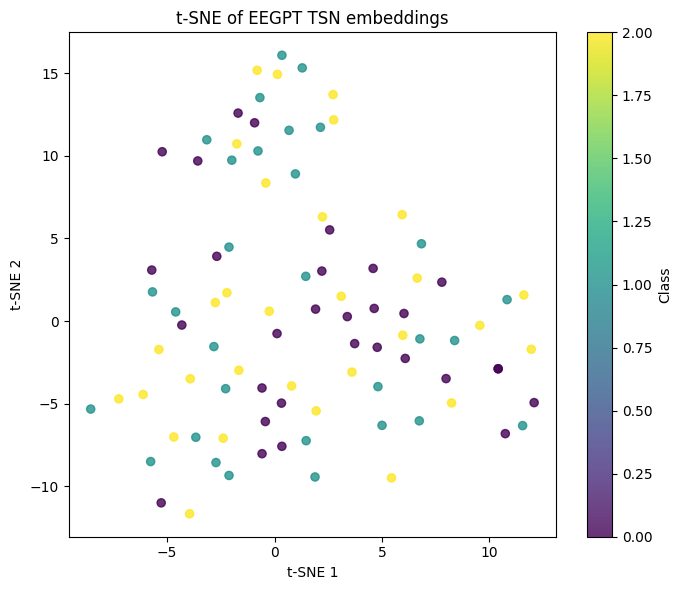

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ========== 1) LOAD WINDOW FEATURES ==========

data = torch.load("eegpt_window_features_fold0.pt", map_location="cpu", weights_only=False)
print(data.keys())


tr_feat = data["tr_feat"]  # torch (Nwin, D)
tr_y    = data["tr_y"]     # torch (Nwin,)
tr_rec  = data["tr_rec"]   # numpy o list

va_feat = data["va_feat"]
va_y    = data["va_y"]
va_rec  = data["va_rec"]

te_feat = data["te_feat"]
te_y    = data["te_y"]
te_rec  = data["te_rec"]

print("WINDOW shapes:", tr_feat.shape, va_feat.shape, te_feat.shape)

# ========== 2) FIX rec_id in modo robusto ==========
def to_numpy_ids(rec):
    # rec può essere numpy array, lista, tensor…
    if isinstance(rec, torch.Tensor):
        rec = rec.cpu().numpy()
    rec = np.asarray(rec)

    # se è dtype=object o stringhe, lo trasformo in codici interi stabili
    if rec.dtype == object or rec.dtype.kind in ("U", "S"):
        uniq, inv = np.unique(rec.astype(str), return_inverse=True)
        return inv.astype(np.int64)
    return rec.astype(np.int64)

tr_rec = to_numpy_ids(tr_rec)
va_rec = to_numpy_ids(va_rec)
te_rec = to_numpy_ids(te_rec)

print("unique rec counts:", len(np.unique(tr_rec)), len(np.unique(va_rec)), len(np.unique(te_rec)))

# ========== 3) TSN pooling (mean) ==========
def tsn_pool(feat, y, rec):
    uniq = np.unique(rec)
    X, Y = [], []
    for rid in uniq:
        m = (rec == rid)
        X.append(feat[m].mean(dim=0))
        Y.append(int(y[m][0].item()))
    return torch.stack(X), torch.tensor(Y, dtype=torch.long)

X_tr, y_tr = tsn_pool(tr_feat, tr_y, tr_rec)
X_va, y_va = tsn_pool(va_feat, va_y, va_rec)
X_te, y_te = tsn_pool(te_feat, te_y, te_rec)

print("TSN shapes:", X_tr.shape, X_va.shape, X_te.shape)
num_classes = int(max(y_tr.max(), y_va.max(), y_te.max()).item() + 1)
print("num_classes:", num_classes)

# ========== 4) StandardScaler (fit su train) ==========
scaler = StandardScaler()
X_tr_np = scaler.fit_transform(X_tr.numpy())
X_va_np = scaler.transform(X_va.numpy())
X_te_np = scaler.transform(X_te.numpy())

Xtr = torch.tensor(X_tr_np, dtype=torch.float32)
Xva = torch.tensor(X_va_np, dtype=torch.float32)
Xte = torch.tensor(X_te_np, dtype=torch.float32)

# ========== 5) MLP classifier ==========
class MLP(nn.Module):
    def __init__(self, d_in, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, n_classes),
        )
    def forward(self, x): return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf = MLP(Xtr.shape[1], num_classes).to(device)

criterion = nn.CrossEntropyLoss()
opt = optim.AdamW(clf.parameters(), lr=1e-3, weight_decay=1e-4)

Xtr, y_tr = Xtr.to(device), y_tr.to(device)
Xva, y_va = Xva.to(device), y_va.to(device)
Xte, y_te = Xte.to(device), y_te.to(device)

@torch.no_grad()
def acc_and_pred(X, y):
    clf.eval()
    logits = clf(X)
    pred = logits.argmax(1)
    acc = (pred == y).float().mean().item()
    return acc, pred.detach().cpu().numpy()

best_va = -1
best_state = None
patience = 30
noimp = 0

for epoch in range(1, 301):
    clf.train()
    opt.zero_grad(set_to_none=True)
    logits = clf(Xtr)
    loss = criterion(logits, y_tr)
    loss.backward()
    opt.step()

    va_acc, _ = acc_and_pred(Xva, y_va)

    if va_acc > best_va:
        best_va = va_acc
        best_state = {k: v.detach().cpu().clone() for k, v in clf.state_dict().items()}
        noimp = 0
    else:
        noimp += 1

    if epoch % 50 == 0 or epoch == 1:
        tr_acc = (logits.argmax(1) == y_tr).float().mean().item()
        print(f"epoch {epoch:03d} | loss={loss.item():.3f} | tr_acc={tr_acc:.3f} | va_acc={va_acc:.3f} | best_va={best_va:.3f}")

    if noimp >= patience:
        print("Early stop.")
        break

if best_state is not None:
    clf.load_state_dict(best_state)

# ========== 6) TEST: confusion matrix ==========
te_acc, te_pred = acc_and_pred(Xte, y_te)
print("\nTEST acc:", te_acc)

cm = confusion_matrix(y_te.cpu().numpy(), te_pred)
print("Confusion matrix:\n", cm)
print("\nReport:\n", classification_report(y_te.cpu().numpy(), te_pred, digits=3))

# ========== 7) t-SNE plot (TSN embeddings) ==========
X_all = np.concatenate([X_tr_np, X_va_np, X_te_np], axis=0)
y_all = np.concatenate([y_tr.cpu().numpy(), y_va.cpu().numpy(), y_te.cpu().numpy()], axis=0)

X_pca = PCA(n_components=min(30, X_all.shape[1]), random_state=0).fit_transform(X_all)
tsne = TSNE(n_components=2, perplexity=min(15, max(5, len(X_all)//4)), init="pca", learning_rate="auto", random_state=0)
X_2d = tsne.fit_transform(X_pca)

plt.figure(figsize=(7,6))
sc = plt.scatter(X_2d[:,0], X_2d[:,1], c=y_all, s=35, alpha=0.8)
plt.colorbar(sc, label="Class")
plt.title("t-SNE of EEGPT TSN embeddings")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()



Quella cella serve a “guardare dentro” le feature finali, proiettandole in 2D per vedere se le classi si separano davvero o no cambiando il seed


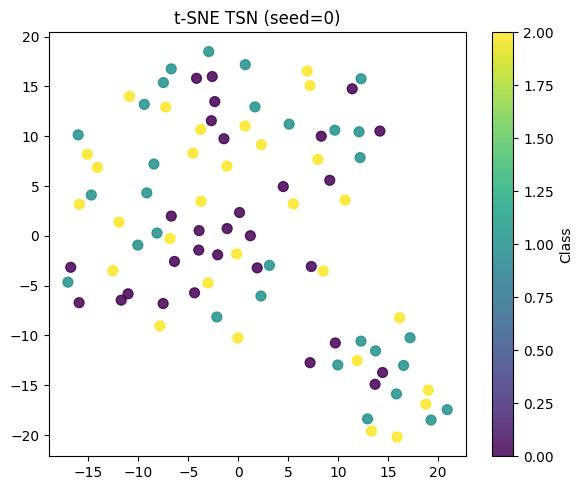

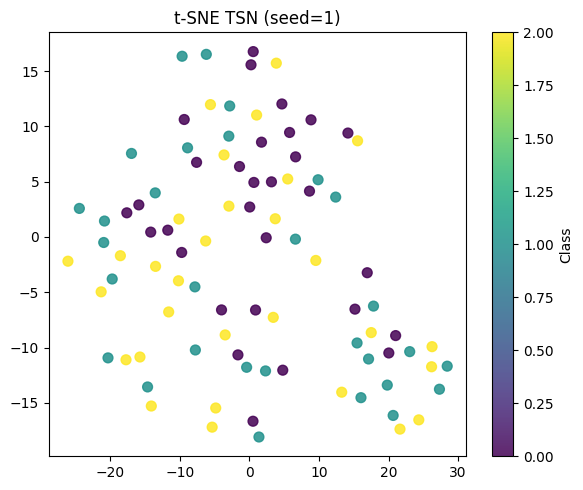

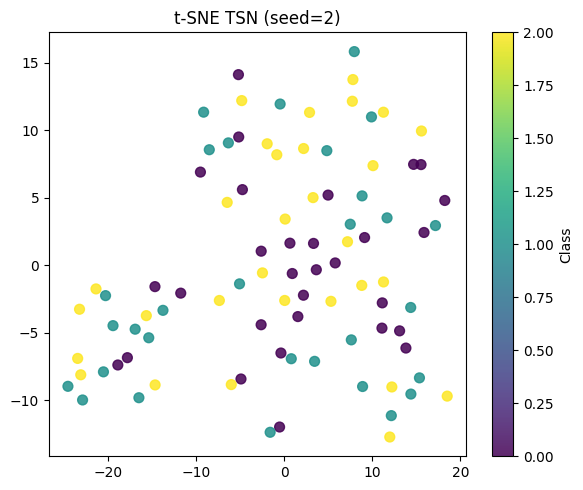

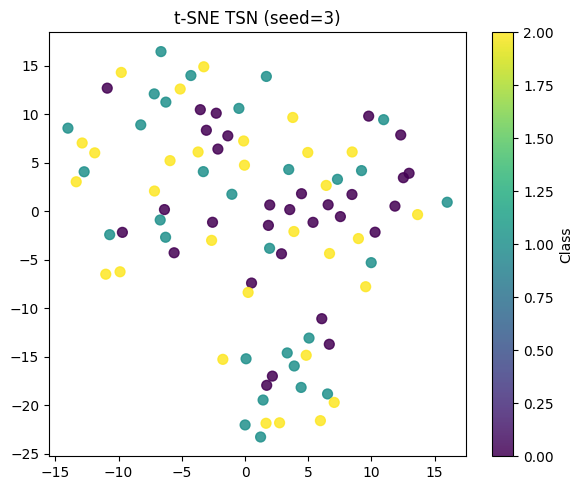

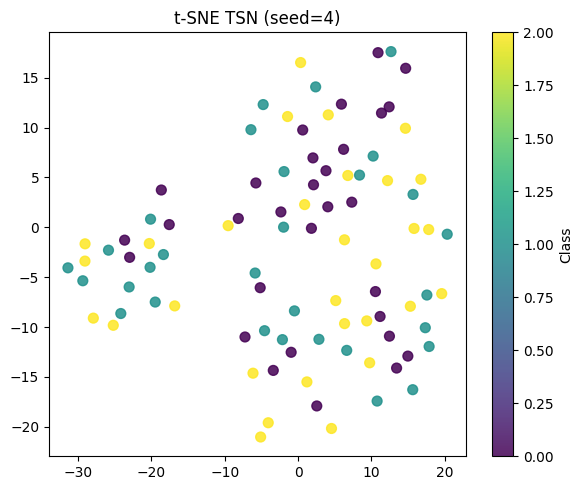

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X = torch.cat([X_tr, X_va, X_te], dim=0).cpu().numpy()
y = torch.cat([y_tr, y_va, y_te], dim=0).cpu().numpy()


# standardizza
Xz = StandardScaler().fit_transform(X)

# PCA
Xp = PCA(n_components=min(30, Xz.shape[1]), random_state=0).fit_transform(Xz)

# t-SNE con più seed
for seed in [0,1,2,3,4]:
    tsne = TSNE(
        n_components=2,
        perplexity=10,
        init="pca",
        learning_rate="auto",
        random_state=seed
    )
    X2 = tsne.fit_transform(Xp)

    plt.figure(figsize=(6,5))
    plt.scatter(X2[:,0], X2[:,1], c=y, s=50, alpha=0.85)
    plt.title(f"t-SNE TSN (seed={seed})")
    plt.colorbar(label="Class")
    plt.tight_layout()
    plt.show()



Visualizza in 2D le feature EEGPT a livello di finestre (window-level), non a livello di registrazioni.

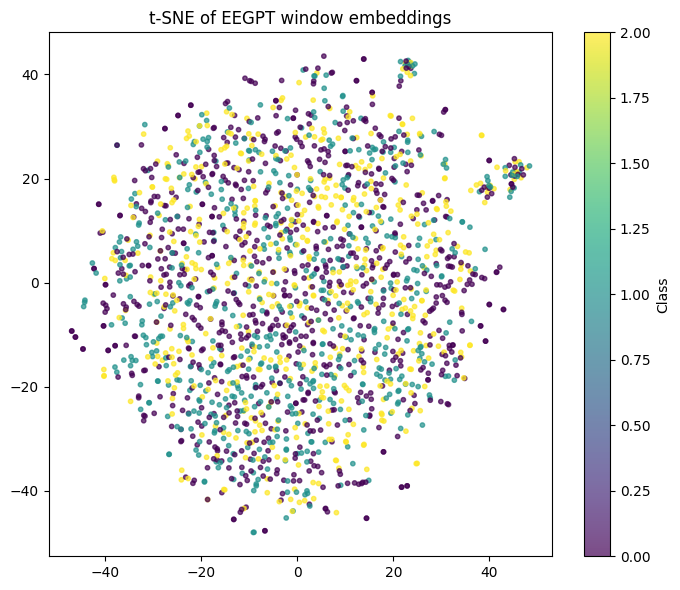

In [21]:
import torch, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

data = torch.load("eegpt_window_features_fold0.pt", map_location="cpu", weights_only=False)

Xw = data["tr_feat"].numpy()   # (Nwin, D)  oppure concatena tr+va+te
yw = data["tr_y"].numpy()

# (opzionale) subsample per velocità
idx = np.random.RandomState(0).choice(len(Xw), size=min(2000, len(Xw)), replace=False)
Xw = Xw[idx]
yw = yw[idx]

Xz = StandardScaler().fit_transform(Xw)
Xp = PCA(n_components=30, random_state=0).fit_transform(Xz)

tsne = TSNE(
    n_components=2,
    perplexity=30,     # con 2000 punti 20-50 ok
    init="pca",
    learning_rate="auto",
    random_state=0
)
X2 = tsne.fit_transform(Xp)

plt.figure(figsize=(7,6))
plt.scatter(X2[:,0], X2[:,1], c=yw, s=10, alpha=0.7)
plt.title("t-SNE of EEGPT window embeddings")
plt.colorbar(label="Class")
plt.tight_layout()
plt.show()


In [ ]:
xb, yb, rid = next(iter(train_loader))
xb = xb.to(device).float()
xb58 = embed_8_to_58(xb)
print("xb:", xb.shape, "xb58:", xb58.shape)

with torch.no_grad():
    f = model.forward_features(xb58)
print("features:", f.shape)


In [ ]:
import numpy as np
import torch

@torch.no_grad()
def extract_eegpt_features(loader):
    feats_all, y_all, rec_all = [], [], []
    for xb, yb, rid in loader:
        xb = xb.to(device).float()     # (B,8,1024)
        xb58 = embed_8_to_58(xb)       # (B,58,1024)

        feats = model.forward_features(xb58)  # (B,D)
        feats_all.append(feats.cpu())
        y_all.append(yb.cpu())
        rec_all.extend(rid.cpu().numpy().tolist())

    return torch.cat(feats_all, 0), torch.cat(y_all, 0), np.array(rec_all)

tr_feat, tr_y, tr_rec = extract_eegpt_features(train_loader)
va_feat, va_y, va_rec = extract_eegpt_features(val_loader)
te_feat, te_y, te_rec = extract_eegpt_features(test_loader)

print("feat shapes:", tr_feat.shape, va_feat.shape, te_feat.shape)

torch.save({
    "tr_feat": tr_feat, "tr_y": tr_y, "tr_rec": tr_rec,
    "va_feat": va_feat, "va_y": va_y, "va_rec": va_rec,
    "te_feat": te_feat, "te_y": te_y, "te_rec": te_rec,
}, "eegpt_window_features_fold0.pt")
print("saved: eegpt_window_features_fold0.pt")



In [ ]:
def tsn_pool(feat, y, rec):
    rec_ids = np.unique(rec)
    Xr, yr = [], []
    for rid in rec_ids:
        m = (rec == rid)
        Xr.append(feat[m].mean(dim=0))     # mean pooling
        yr.append(y[m][0])
    return torch.stack(Xr, 0), torch.stack(yr, 0), rec_ids

Xtr_tsn, ytr_tsn, rtr = tsn_pool(tr_feat, tr_y, tr_rec)
Xva_tsn, yva_tsn, rva = tsn_pool(va_feat, va_y, va_rec)
Xte_tsn, yte_tsn, rte = tsn_pool(te_feat, te_y, te_rec)

print("TSN shapes:", Xtr_tsn.shape, Xva_tsn.shape, Xte_tsn.shape)


MLP classifier

In [ ]:
class MLP(nn.Module):
    def __init__(self, d_in, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_classes),
        )
    def forward(self, x): return self.net(x)

n_classes = 3
clf = MLP(Xtr_tsn.shape[1], n_classes).to(device)

opt = torch.optim.AdamW(clf.parameters(), lr=1e-3, weight_decay=1e-4)
crit = nn.CrossEntropyLoss()

Xtr = Xtr_tsn.to(device).detach()
ytr = ytr_tsn.to(device).detach()
Xva = Xva_tsn.to(device).detach()
yva = yva_tsn.to(device).detach()

best = 0
for epoch in range(200):
    clf.train()
    opt.zero_grad(set_to_none=True)
    logits = clf(Xtr)
    loss = crit(logits, ytr)
    loss.backward()
    opt.step()

    if epoch % 20 == 0:
        clf.eval()
        with torch.no_grad():
            va_pred = clf(Xva).argmax(1)
            va_acc = (va_pred == yva).float().mean().item()
        print(f"ep{epoch:03d} loss={loss.item():.3f} va_acc={va_acc:.3f}")
        best = max(best, va_acc)
print("best val acc:", best)


In [ ]:
clf.eval()
with torch.no_grad():
    te_pred = clf(Xte_tsn.to(device)).argmax(1).cpu().numpy()
y_true = yte_tsn.cpu().numpy()

cm = confusion_matrix(y_true, te_pred)
print("Confusion Matrix:\n", cm)
print(classification_report(y_true, te_pred, digits=3))


SVM RBF

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=10, gamma="scale"))
])

svm.fit(Xtr_tsn.numpy(), ytr_tsn.numpy())
te_pred = svm.predict(Xte_tsn.numpy())

cm = confusion_matrix(yte_tsn.numpy(), te_pred)
print("Confusion Matrix:\n", cm)
print(classification_report(yte_tsn.numpy(), te_pred, digits=3))


tsne

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

X_emb = torch.cat([Xtr_tsn, Xva_tsn, Xte_tsn], 0).numpy()
y_emb = torch.cat([ytr_tsn, yva_tsn, yte_tsn], 0).numpy()

X_scaled = StandardScaler().fit_transform(X_emb)
X_pca = PCA(n_components=min(30, X_scaled.shape[1]), random_state=0).fit_transform(X_scaled)

tsne = TSNE(n_components=2, perplexity=10, init="pca", learning_rate="auto", random_state=0)
X_2d = tsne.fit_transform(X_pca)

plt.figure(figsize=(7,6))
sc = plt.scatter(X_2d[:,0], X_2d[:,1], c=y_emb, s=40, alpha=0.8)
plt.colorbar(sc, label="Class (0/1/2)")
plt.title("t-SNE of EEGPT TSN embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


In [ ]:
import torch

def forward_autosize(model, xb_8x1024, channels, CHANNEL_DICT, device):
    xb_8x1024 = xb_8x1024.to(device).float()
    B, C8, T = xb_8x1024.shape

    # === 1) leggiamo dal modello cosa vuole ===
    # troviamo num_patches nel sottomodulo giusto
    core = None
    for _, m in model.named_modules():
        if hasattr(m, "num_patches"):
            core = m
            break
    assert core is not None, "Non trovo num_patches nel modello"

    C_model, N_model = core.num_patches
    patch_size = 64
    T_model = N_model * patch_size

    print("MODEL EXPECTS:")
    print("C_model =", C_model)
    print("N_model =", N_model)
    print("T_model =", T_model)

    # === 2) mappa canali ===
    chan_ids = [CHANNEL_DICT[c] for c in channels]

    # === 3) padding temporale ===
    xb_pad = torch.zeros(B, 8, T_model, device=device)
    xb_pad[:, :, :min(T, T_model)] = xb_8x1024[:, :, :min(T, T_model)]

    # === 4) embedding canali ===
    xb_C = torch.zeros(B, C_model, T_model, device=device)
    xb_C[:, chan_ids, :] = xb_pad

    # === 5) patchify ===
    xb_patched = xb_C.view(B, C_model, N_model, patch_size) \
                     .permute(0, 2, 1, 3) \
                     .contiguous()

    print("xb_patched shape:", xb_patched.shape)

    # === 6) forward ===
    out = model(xb_patched)
    return out


# TEST
xb = torch.randn(2, 8, 1024).to(device)
out = forward_autosize(model, xb, channels, CHANNEL_DICT, device)

if isinstance(out, dict):
    print("out keys:", out.keys())
    out = out.get("logits", out)

print("FINAL OUTPUT SHAPE:", out.shape)



In [ ]:

import torch
def eegpt_forward_simple(model, xb_8x1024, channels, CHANNEL_DICT, device):
    """
    xb_8x1024: (B, 8, 1024)
    """
    xb_8x1024 = xb_8x1024.to(device).float()
    B, _, T = xb_8x1024.shape

    C_model = 58
    T_model = 1024  # classifier lavora a 4s

    chan_ids = [CHANNEL_DICT[c] for c in channels]

    # embed 8 -> 58 canali
    xb_58 = torch.zeros(B, C_model, T_model, device=device)
    xb_58[:, chan_ids, :] = xb_8x1024

    # PASSA (B, 58, 1024), NON patchificato
    return model(xb_58)



In [ ]:
xb = torch.randn(2, 8, 1024).to(device)
out = eegpt_forward_simple(model, xb, channels, CHANNEL_DICT, device)

if isinstance(out, dict):
    print(out.keys())
    out = out.get("logits", out)

print("OK output shape:", out.shape)


In [ ]:
import torch

B = 2
xb = torch.randn(B, 8, 1024).to(device)

# embed 8 -> 58
chan_ids = [CHANNEL_DICT[c] for c in channels]
xb_58 = torch.zeros(B, 58, 1024, device=device)
xb_58[:, chan_ids, :] = xb

out = model(xb_58)

if isinstance(out, dict):
    print("keys:", out.keys())
    out = out.get("logits", out)

print("OK output shape:", out.shape)


In [ ]:
from pathlib import Path
import os, sys

%cd /content
!git clone -q https://github.com/BINE022/EEGPT.git

print("After clone, /content contains:", os.listdir("/content")[:20])
print("EEGPT exists:", Path("/content/EEGPT").exists())
print("downstream exists:", Path("/content/EEGPT/downstream").exists())


In [ ]:
from pathlib import Path
import sys, os

root = Path("/content/EEGPT")
print("root exists:", root.exists())
print("downstream exists:", (root/"downstream").exists())
print("cwd:", os.getcwd())

# 1) forza python a vedere il repo (in cima)
sys.path.insert(0, str(root))
print("sys.path[0]:", sys.path[0])

# 2) crea __init__.py (package “classico”)
init_files = [
    root/"downstream/__init__.py",
    root/"downstream/Modules/__init__.py",
    root/"downstream/Modules/models/__init__.py",
]
for f in init_files:
    f.parent.mkdir(parents=True, exist_ok=True)
    f.touch(exist_ok=True)

print("Created init files:", [str(f) for f in init_files])

# 3) importa
from downstream.Modules.models.EEGPT_mcae_finetune import EEGPTClassifier, CHANNEL_DICT
print("Import OK")


In [ ]:
import importlib.util
from pathlib import Path

path = Path("/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py")
assert path.exists(), f"Non trovo il file: {path}"

spec = importlib.util.spec_from_file_location("eegpt_mcae_finetune", str(path))
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

EEGPTClassifier = mod.EEGPTClassifier
CHANNEL_DICT = mod.CHANNEL_DICT

print("Import OK (via file). CHANNEL_DICT size:", len(CHANNEL_DICT))


In [ ]:
import torch, numpy as np
from scipy.signal import resample_poly

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
channels = [c.upper().strip('.') for c in my_channels]
for c in channels:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto: {c}"
print("Channels:", channels)


In [ ]:
FS_SRC = 250
FS_TGT = 256
WIN_SEC = 4.0
TGT_LEN = int(FS_TGT * WIN_SEC)   # 1024
STRIDE_SEC = 2.0
STRIDE = int(FS_TGT * STRIDE_SEC)

def resample_to_256(x_8xT):
    return resample_poly(x_8xT, 128, 125, axis=1)

def make_windows(x_8xT_256, win_len=TGT_LEN, stride=STRIDE):
    C, T = x_8xT_256.shape
    xs = []
    for start in range(0, T - win_len + 1, stride):
        xs.append(x_8xT_256[:, start:start+win_len])
    return np.stack(xs, axis=0) if xs else None


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

rng = np.random.default_rng(42)

def make_dummy_session(seconds=90, n_classes=4):
    T = int(FS_SRC * seconds)
    x = rng.normal(size=(8, T)).astype(np.float32)
    y = rng.integers(0, n_classes)
    return x, y

N_SESS = 10
N_CLASSES = 4

X_all, y_all = [], []
for _ in range(N_SESS):
    raw, y = make_dummy_session()
    raw_256 = resample_to_256(raw)
    Xw = make_windows(raw_256)
    if Xw is None:
        continue
    X_all.append(Xw)
    y_all += [y] * len(Xw)

X_all = np.concatenate(X_all, axis=0)
y_all = np.array(y_all, dtype=np.int64)
print("Dataset finestrato:", X_all.shape, y_all.shape)

X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=0)
X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=0)

train_loader = DataLoader(TensorDataset(torch.tensor(X_tr), torch.tensor(y_tr)), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(torch.tensor(X_va), torch.tensor(y_va)), batch_size=64, shuffle=False)
test_loader  = DataLoader(TensorDataset(torch.tensor(X_te), torch.tensor(y_te)), batch_size=64, shuffle=False)


NameError: name 'FS_SRC' is not defined

In [ ]:
from pathlib import Path

ckpt_path = Path("/content/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt")
use_pretrained = ckpt_path.exists()
print("use_pretrained:", use_pretrained)

model = EEGPTClassifier(
    num_classes=N_CLASSES,
    ckpt_path=str(ckpt_path) if use_pretrained else None,
    channels=channels,
    sample_rate=FS_TGT,
    input_time_length=int(WIN_SEC)
).to(device)

print("Model init OK")


In [ ]:
from pathlib import Path
import os, sys

%cd /content

# clona solo se non esiste già
if not Path("/content/EEGPT").exists():
    !git clone https://github.com/BINE022/EEGPT.git
else:
    print("Repo già presente.")

print("After clone, /content contains:", os.listdir("/content")[:20])
print("EEGPT exists:", Path("/content/EEGPT").exists())
print("downstream exists:", Path("/content/EEGPT/downstream").exists())

# metti il repo in cima al path
sys.path.insert(0, "/content/EEGPT")

from downstream.Modules.models.EEGPT_mcae_finetune import EEGPTClassifier, CHANNEL_DICT
print("Import OK")


In [ ]:
import sys
from pathlib import Path
sys.path.append("/content/EEGPT")
from downstream.Modules.models.EEGPT_mcae_finetune import EEGPTClassifier, CHANNEL_DICT


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


In [ ]:
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
channels_clean = [c.upper().strip('.') for c in my_channels]

# check nel dizionario
for c in channels_clean:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto: {c}"
print("Channels clean:", channels_clean)


In [ ]:

%cd /content
if not Path("EEGPT").exists():
    !git clone -q https://github.com/BINE022/EEGPT.git
%cd EEGPT
!pip -q in
!pip install -r requirements.txt


In [ ]:

stall -r requirements.txt

# --- Import modello EEGPT ---
if str(Path.cwd()) not in sys.path:
    sys.path.append(str(Path.cwd()))
from downstream.Modules.models.EEGPT_mcae_finetune import EEGPTClassifier, CHANNEL_DICT

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --------- 1) Config canali & sampling ----------
# I TUOI CANALI (OpenBCI 8ch)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]  # case-insensitive
# Verifica che siano nel dizionario del repo (usa maiuscole interne)
channels = []
for ch in my_channels:
    key = ch.upper()
    if key not in CHANNEL_DICT:
        raise ValueError(f"Canale non riconosciuto da EEGPT: {ch}. Controlla la nomenclatura 10-20.")
    channels.append(ch)  # tieni l'originale; il wrapper fa upper() da solo

print("Canali passati a EEGPT:", channels)

FS_SRC = 250    # OpenBCI
FS_TGT = 256    # EEGPT pretrain
WIN_SEC = 4.0   # 4 secondi
TGT_LEN = int(FS_TGT * WIN_SEC)  # 1024 campioni
STRIDE_SEC = 2.0  # overlap 50%
STRIDE = int(FS_TGT * STRIDE_SEC)

# --------- 2) Funzioni: resample 250->256 e segmentazione (C,T)->(N,C,1024) ----------
def resample_to_256(x_8xT, fs_src=250, fs_tgt=256):
    # x shape: (C=8, T)
    # usa resample_poly: fattori piccoli e precisi (up=128, down=125 per 250->256)
    up, down = 128, 125
    return resample_poly(x_8xT, up, down, axis=1)

def make_windows(x_8xT_256, win_len=TGT_LEN, stride=STRIDE):
    # x: (C=8, T256)
    C, T = x_8xT_256.shape
    xs = []
    for start in range(0, T - win_len + 1, stride):
        seg = x_8xT_256[:, start:start+win_len]  # (8,1024)
        xs.append(seg)
    return np.stack(xs, axis=0) if xs else None  # (N, 8, 1024)

# --------- 3) Qui simulo il CARICAMENTO dei tuoi dati grezzi ---------
# Sostituisci questa parte con il tuo loader reale (file .csv/.txt/.edf già sincronizzati).
# Creo un dummy "per sessione": 90 s @250 Hz -> 22500 campioni
rng = np.random.default_rng(42)
def make_dummy_session(seconds=90, n_classes=4):
    T = int(FS_SRC * seconds)
    x = rng.normal(size=(8, T)).astype(np.float32)           # (8, T250)
    y_label = rng.integers(0, n_classes)                     # un'etichetta per la sessione (esempio)
    return x, y_label

# Costruisco dataset fittizio (10 sessioni -> poi segmentate in finestre)
N_SESS = 10
N_CLASSES = 4
X_all, y_all = [], []
for _ in range(N_SESS):
    raw, y = make_dummy_session(seconds=90, n_classes=N_CLASSES)     # (8, T250)
    raw_256 = resample_to_256(raw)                                   # (8, T256)
    Xw = make_windows(raw_256)                                       # (N, 8, 1024)
    if Xw is None:
        continue
    X_all.append(Xw)
    y_all += [y]*len(Xw)

X_all = np.concatenate(X_all, axis=0)  # (N, 8, 1024)
y_all = np.array(y_all, dtype=np.int64)
print("Dataset dummy finestrato:", X_all.shape, y_all.shape)

# --------- 4) Split e DataLoader ----------
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=0)
X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=0)  # 60/20/20

BATCH = 64
train_loader = DataLoader(TensorDataset(torch.tensor(X_tr), torch.tensor(y_tr)), batch_size=BATCH, shuffle=True,  pin_memory=True)
val_loader   = DataLoader(TensorDataset(torch.tensor(X_va), torch.tensor(y_va)), batch_size=BATCH, shuffle=False, pin_memory=True)
test_loader  = DataLoader(TensorDataset(torch.tensor(X_te), torch.tensor(y_te)), batch_size=BATCH, shuffle=False, pin_memory=True)

# --------- 5) Modello EEGPT con i TUOI 8 canali ----------
ckpt_path = Path("checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt")  # metti qui il ckpt se ce l'hai
use_pretrained = ckpt_path.exists()

model = EEGPTClassifier(
    num_classes=N_CLASSES,
    ckpt_path=str(ckpt_path) if use_pretrained else None,
    channels=channels,        # <<<<<< 8 canali: il resto è "mascherato"
    sample_rate=FS_TGT,       # 256 Hz (dopo il resample)
    input_time_length=int(WIN_SEC)
).to(device)
print("EEGPT init OK. Pretrained:", use_pretrained)

# --------- 6) Linear probing (congela il backbone) ----------
for p in model.parameters():
    p.requires_grad = False

# EEGPTClassifier in genere restituisce direttamente i logits
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-3, weight_decay=1e-4)

def forward_logits(xb):
    xb = xb.to(device).float()  # (B, 8, 1024)
    out = model(xb)
    if isinstance(out, dict) and "logits" in out:
        out = out["logits"]
    return out

@torch.no_grad()
def eval_loader(loader):
    model.eval()
    yp, yt = [], []
    for xb, yb in loader:
        logits = forward_logits(xb)
        yp.append(logits.argmax(1).cpu().numpy())
        yt.append(yb.numpy())
    yp = np.concatenate(yp); yt = np.concatenate(yt)
    return float(accuracy_score(yt, yp)), confusion_matrix(yt, yp, labels=list(range(N_CLASSES)))

EPOCHS, PATIENCE = 5, 3
best_val, noimp = -1.0, 0
print("\n=== Linear Probing (backbone congelato) ===")
for ep in range(1, EPOCHS+1):
    model.train()
    run, seen = 0.0, 0
    pbar = tqdm(train_loader, desc=f"[LP] {ep}/{EPOCHS}")
    for xb, yb in pbar:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        logits = forward_logits(xb)
        loss = criterion(logits, yb)
        loss.backward(); opt.step()
        bs = xb.size(0); run += loss.item()*bs; seen += bs
        pbar.set_postfix(loss=run/max(1,seen))
    va_acc, _ = eval_loader(val_loader)
    print(f"Val ACC: {va_acc:.3f}")
    if va_acc > best_val: best_val, noimp = va_acc, 0
    else:
        noimp += 1
        if noimp >= PATIENCE:
            print("Early stop.")
            break

# --------- 7) Test ----------
te_acc, cm = eval_loader(test_loader)
print("\n=== TEST ===")
print("Test ACC:", te_acc)
print("Confusion Matrix:\n", cm)
print(classification_report(
    np.concatenate([yb.numpy() for _, yb in test_loader]),
    np.concatenate([forward_logits(xb).argmax(1).cpu().numpy() for xb, _ in test_loader]),
    digits=3
))

